# Introduction and Purpose

As soemone who is interested in personal finance, this project is to introduce myself to stock evaluation metrics by collecting relevant data and analyzing it to learn about the fundamental metrics and how they can be used to determine stock prices.  AFterwards, I will develop a model based on the metrics to predict what an analyst may recommend to do with a stock (buy, sell, etc.).

In [11]:
# Begin by importing relevant libraries for the project

# For data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# To extract fundamental data from FinViz
from bs4 import BeautifulSoup as bs
import requests

# To import Yahoo! Finance data
import yfinance as yf

# Part 1: Data Collection

After researching the topic, I found that several sites do not update their data based on current stock prices but rather quarterly to coincide with earnings reports.  To get the most up to date data for my analysis, I found that I could perform webscraping with BeautifulSoup to FinViz.com which has up to date metrics.  Below are two functions created to help search for wanted metrics and collect the values.

In [22]:
# Functions to get and parse data from FinViz

# Function takes soup object and a single metric and provides the appropriate value.  This is specific to FinViz.com.
def fundamental_metric(soup, metric):
    return soup.find(text = metric).find_next(class_='snapshot-td2').text

# Function for a dataframe with indexes as stock tickers and blank columns as the metrics you want data for, it
# inputs the values to the dataframe if they can be found.
def get_fundamental_data(df):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}
    for symbol in df.index:
        try:
            url = ("http://finviz.com/quote.ashx?t=" + symbol.lower())
            soup = bs(requests.get(url, headers=headers).content)
            for metric in df.columns:                
                df.loc[symbol,metric] = fundamental_metric(soup,metric)
            # optional print statement for troubleshooting
            print(symbol, 'complete')                
        except Exception as e:
            print (symbol, 'not found')
    return df

## Stock Selection and Dataframe Prep

For this analysis, I decided I wanted to analyze the S&P 500 (as it stands right now) and a handful of stocks I found personal interest in.  For the S&P 500 stocks, I used a list I found online with the ticker symbols and company names and imported that into the notebook via csv. For the stocks of personal interest, I wrote them out in a list.

As for metrics, I decided to collect several basic ones as suggested by financial pages.  I put these in a list as well to help with creating the data frame later on.

As for dataframe prep, for the functions written earlier, the index needs to be the stock tickers and the columns need to be the metrics we would like to collect.  This is simply done by creating a dataframe in the method noted below.

In [23]:
# S&P 500 stocks
sp500 = pd.read_csv('sp500.csv')
stock_list1 = sp500['Symbol'].tolist()

# Personal Interest Stocks
stock_list2 = ['WSBF','DOW','C','VIAC','DRI','RDS-A','SPG','STOR','FCPT','CWEN','BBL','GOGL','PSA','DLR','AMT','STAG','JPM','V','MA','ATH','RKT','WTM','AHCO','ACY','AFCG']

# Metrics of interest to take from FinViz.com
metric = ['P/B',
'P/E',
'Forward P/E',
'PEG',
'Debt/Eq',
'EPS (ttm)',
'Dividend %',
'ROE',
'ROI',
'EPS Q/Q'
]

# Combine stock lists and make unique to ensure there are not any duplicates
stock_list = np.unique(stock_list1 + stock_list2)

# Create dataframe for data collection
df = pd.DataFrame(index=stock_list,columns=metric)

## Data Scraping and Cleaning

Now that the dataframe is set up, we can use it with the function created earlier to collect the data.  While this data is fairly clean, it does need some minor brushing up (removing % signs) and converting the values to numeric.

In [24]:
# Call function to get data (for ~515 tickers, it takes 100 seconds)
df = get_fundamental_data(df)

# Clean up the data
df['Dividend %'] = df['Dividend %'].str.replace('%', '')
df['ROE'] = df['ROE'].str.replace('%', '')
df['ROI'] = df['ROI'].str.replace('%', '')
df['EPS Q/Q'] = df['EPS Q/Q'].str.replace('%', '')
df = df.apply(pd.to_numeric, errors='coerce') # coerce as sometimes "-" will appear when there is no value

A complete
AAL complete
AAP complete
AAPL complete
ABBV complete
ABC complete
ABMD complete
ABT complete
ACN complete
ACY complete
ADBE complete
ADI complete
ADM complete
ADP complete
ADSK complete
AEE complete
AEP complete
AES complete
AFCG complete
AFL complete
AHCO complete
AIG complete
AIZ complete
AJG complete
AKAM complete
ALB complete
ALGN complete
ALK complete
ALL complete
ALLE complete
AMAT complete
AMCR complete
AMD complete
AME complete
AMGN complete
AMP complete
AMT complete
AMZN complete
ANET complete
ANSS complete
ANTM complete
AON complete
AOS complete
APA complete
APD complete
APH complete
APTV complete
ARE complete
ATH complete
ATO complete
ATVI complete
AVB complete
AVGO complete
AVY complete
AWK complete
AXP complete
AZO complete
BA complete
BAC complete
BAX complete
BBL complete
BBY complete
BDX complete
BEN complete
BF.B not found
BIIB complete
BIO complete
BK complete
BKNG complete
BKR complete
BLK complete
BLL complete
BMY complete
BR complete
BRK.B not found
BSX

## Additional Yahoo! Finance Data

Some information was not available from FinViz that I wanted to incorporate for my analysis.  Looking at other data sources, I found that Yahoo! Finance was able to easily provide me with it (industry, recommendation metrics from experts, and company name); so, I decided to incorporate that data set along with current price.

This is wrapped in a function as shown below where you input the dataframe from above and you get an updated data frame with all the new data and a list of errors to explore should something unexpected happen.

*Note:* This function takes about 4-5 seconds per stock to run and it can take ~45 minutes to complete for a list of ~515 tickers

In [25]:
def get_yahoo_data(df):

    # Variables I want from yfinance
    industry = []
    currentPrice = []
    recommendationKey = []
    recommendationMean = []
    shortName = []

    # ErrorLog
    errorLog = []

    # this takes about 4 seconds per stock, so for larger lists (like the S&P 500), it takes about 40 minutes
    for stock in df.index:
        info = yf.Ticker(stock)
        try:
            industry.append(info.info['sector'])
        except KeyError:
            industry.append(np.nan)
            errorLog.append(stock + ' industry error')

        try:
            currentPrice.append(info.info['currentPrice'])
        except KeyError:
            currentPrice.append(np.nan)
            errorLog.append(stock + ' currentPrice error')

        try:
            recommendationKey.append(info.info['recommendationKey'])
        except KeyError:
            recommendationKey.append(np.nan)
            errorLog.append(stock + ' recommendationKey error')

        try:
            recommendationMean.append(info.info['recommendationMean'])
        except KeyError:
            recommendationMean.append(np.nan)
            errorLog.append(stock + ' recommendationMean error')

        try:
            shortName.append(info.info['shortName'])
        except KeyError:
            shortName.append(np.nan)
            errorLog.append(stock + ' shortName error')

        # optional print statement for troubleshooting
        print(stock, 'complete') 

    df['Industry'] = industry
    df['currentPrice'] = currentPrice
    df['recommendationKey'] = recommendationKey
    df['recommendationMean'] = recommendationMean
    df['shortName'] = shortName

    return df, errorLog

In [26]:
# Collect Data
df, errorLog = get_yahoo_data(df)

A complete
AAL complete
AAP complete
AAPL complete
ABBV complete
ABC complete
ABMD complete
ABT complete
ACN complete
ACY complete
ADBE complete
ADI complete
ADM complete
ADP complete
ADSK complete
AEE complete
AEP complete
AES complete
AFCG complete
AFL complete
AHCO complete
AIG complete
AIZ complete
AJG complete
AKAM complete
ALB complete
ALGN complete
ALK complete
ALL complete
ALLE complete
AMAT complete
AMCR complete
AMD complete
AME complete
AMGN complete
AMP complete
AMT complete
AMZN complete
ANET complete
ANSS complete
ANTM complete
AON complete
AOS complete
APA complete
APD complete
APH complete
APTV complete
ARE complete
ATH complete
ATO complete
ATVI complete
AVB complete
AVGO complete
AVY complete
AWK complete
AXP complete
AZO complete
BA complete
BAC complete
BAX complete
BBL complete
BBY complete
BDX complete
BEN complete
BF.B complete
BIIB complete
BIO complete
BK complete
BKNG complete
BKR complete
BLK complete
BLL complete
BMY complete
BR complete
BRK.B complete
BSX c

Now that collecting data is done, I am going to save the information to a csv file so that I have an easy return point and do not have to wait for the data to be recollected for future analysis.  If this were something that were to be used daily, an area of improvement would be working on getting the Yahoo! Finance data quicker.

In [27]:
df.index.name='Stock'
df.to_csv('all_stocks.csv', encoding='utf-8-sig')

As for the error log, I noticed that there are 4 stock tickers that it had issues collecting data for.  Further improvement would be to troubleshoot what the issues are with these stocks to get a more complete data set, but for preliminary analysis, this is less than 1% of the data set and is insignificant for this use case.

# Part 2: Exploratory Data Analysis

To being the analysis, I wanted to start out by seeing what industries have the best average "buy" recommendations from Yahoo! Finance.  For this, I looked at the recommendationMean value which is a mesure from 1-5 where 1 is a very undervalued stock (suggested to buy), 3 is a holding recommendation, and 5 is an overvalued recommendation (suggestion to sell).

Plotting out these values by industry, I see that all industries are currently below a 2.5, meaning that, on average, they are suggesting to buy a stock, regardless of what industry it is in, which makes sense being in a bull market.  However, the Healthcare industry currently has the lowest value.  Therefore, to limit my future analysis, I will be focusing on this industry to see if I can see why these may have good recommendations.

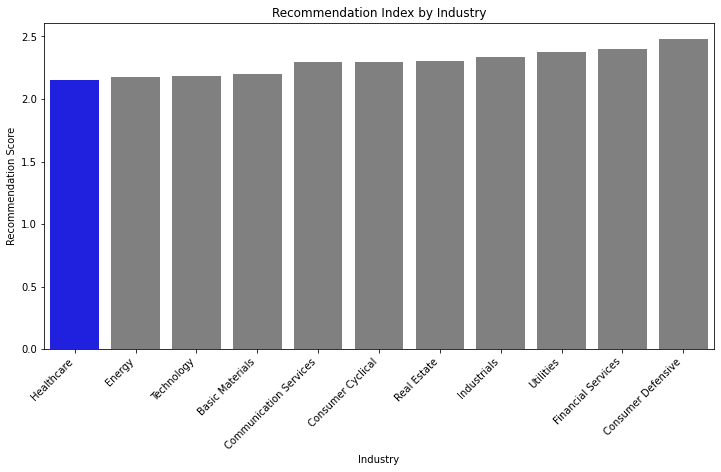

In [3]:
# Find What industry currently has the best chance of having a "Buy" stock
df2 = pd.read_csv('all_stocks.csv', encoding='utf-8-sig')

industry_recommendation = df2.groupby('Industry').recommendationMean.mean().sort_values()
clrs = ['blue' if (x == min(industry_recommendation)) else 'grey' for x in industry_recommendation ]

plt.figure(figsize=(12,6))
sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)

ax = sns.barplot(x = industry_recommendation.index,
                 y = industry_recommendation,
                 palette = clrs)
                 
ax.set(title = 'Recommendation Index by Industry',
       ylabel = 'Recommendation Score')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

## Top and Bottom 10 Comparisons

As someone who is exploring these metrics for the first time, I wanted to validate what I read online by seeing if the trends noted online have any backing to them.  For this, I wanted to start off by looking at the top and bottom 10 stocks in healthcare for each metric as I imagine there should be a stark contrast in recommendations if the advice I am getting holds up.

### P/E Ratios

P/E Ratio is used by analysts to determine the value of a stock against competitors in an industry.  To see what the range of P/E ratios are, I filtered the dataset to only those in the healthcare industry and plotted the top and bottom 10 P/E ratios.

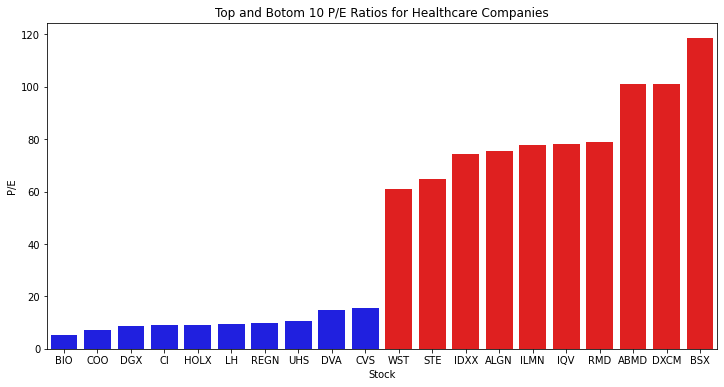

In [4]:
#Filter to fin services
dfhealth = df2[(df2.Industry == 'Healthcare')]

# show only the top and bottom 10 of each
df_top = dfhealth.nlargest(10, columns = 'P/E')
df_top['color'] = 'red'
df_bot = dfhealth.nsmallest(10, columns = 'P/E')
df_bot['color'] = 'blue'
# combine and sort values in ascending order
dfpe = pd.concat([df_top, df_bot]).sort_values('P/E')

# plot
plt.figure(figsize = (12,6))
ax = sns.barplot(data = dfpe,
            x = 'Stock',
            y = 'P/E',
            palette = dfpe['color'])
ax.set(title = 'Top and Botom 10 P/E Ratios for Healthcare Companies')
plt.show()

To see if these were seen as good buys by analysts, I kept the same layout, but instead of plotting the P/E value, I decided to plot the Recommendation Mean value for each company.  Looking at these, it seems that the P/E ratio may not be a good determining factor in isolation as the values seem to not have any visual correlation with the P/E Ratio.

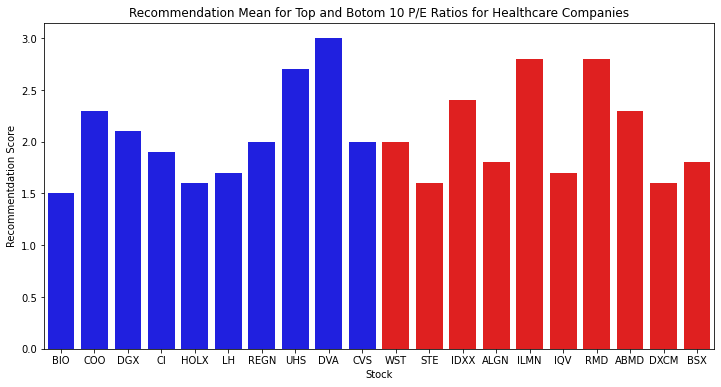

In [5]:
# do the same with seaborn
plt.figure(figsize = (12,6))
ax = sns.barplot(data = dfpe,
            x = 'Stock',
            y = 'recommendationMean',
            palette = dfpe['color'])
ax.set(title = 'Recommendation Mean for Top and Botom 10 P/E Ratios for Healthcare Companies',
       ylabel = 'Recommentdation Score')
plt.show()

### Earnings Per Share (trailing tweleve months)

Earning Per Share (EPS) show how efficiently a companies revenue may be flowing down to investors.  NASDAQ says that the higher a company's EPS, the more the shares are worth because they suggest to purchase a company's stock when earnings are high.  The chart below shows the top and bottom 10 EPS values for comapnies in Healthcare.

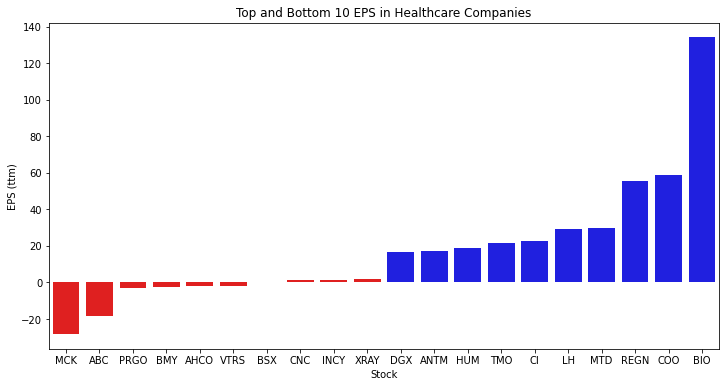

In [6]:
# show only the top and bottom 10 of each
df_top = dfhealth.nlargest(10, columns = 'EPS (ttm)')
df_top['color'] = 'blue'
df_bot = dfhealth.nsmallest(10, columns = 'EPS (ttm)')
df_bot['color'] = 'red'
# combine and sort values in ascending order
dfeps = pd.concat([df_top, df_bot]).sort_values('EPS (ttm)')

# plot
plt.figure(figsize = (12,6))
ax = sns.barplot(data = dfeps,
            x = 'Stock',
            y = 'EPS (ttm)',
            palette=dfeps['color'])
ax.set(title = 'Top and Bottom 10 EPS in Healthcare Companies')
plt.show()

As before, I also wanted to look at the Recommendation Score values for these companies.  It appears that there is no large difference for those with low or high EPS values so this may also not be a good indicator.

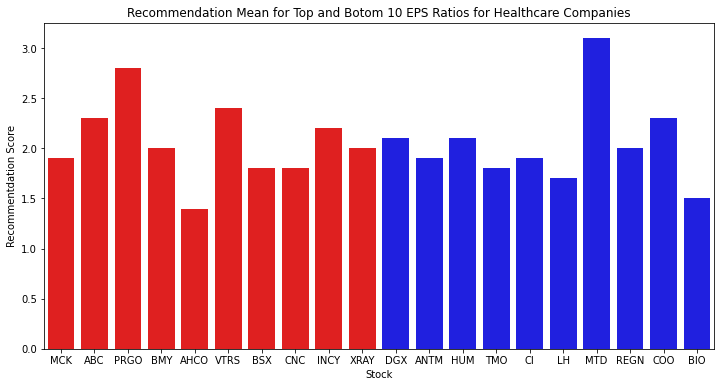

In [7]:
plt.figure(figsize = (12,6))
ax = sns.barplot(data = dfeps,
            x = 'Stock',
            y = 'recommendationMean',
            palette = dfeps['color'])
ax.set(title = 'Recommendation Mean for Top and Botom 10 EPS Ratios for Healthcare Companies',
       ylabel = 'Recommentdation Score')
plt.show()

### PEG Ratio

While P/E Ratio and EPS were not excellent measures to look at based on my previous analysis, there is a possibility putting them together can yeild better results.  For this, I will look at the PEG Ratio which is the P/E Ratio divided by the tweleve month growth rate.  Typically values under 1 are sought after as good deals.  Below is a chart with the top and bottom 10 PEG values in the Healthcare Industry.

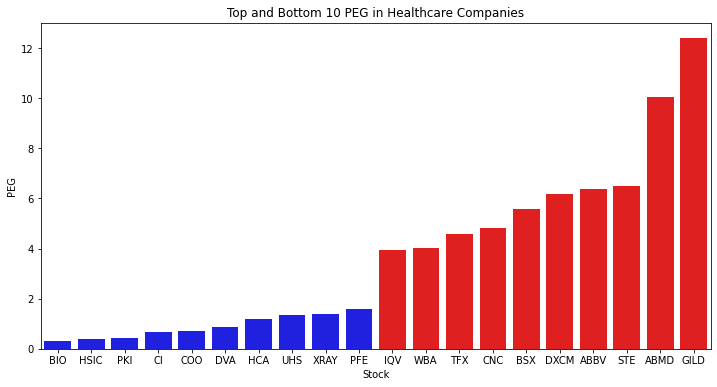

In [8]:
# show only the top and bottom 10 of each
df_top = dfhealth.nlargest(10, columns = 'PEG')
df_top['color'] = 'red'
df_bot = dfhealth.nsmallest(10, columns = 'PEG')
df_bot['color'] = 'blue'
# combine and sort values in ascending order
dfpeg = pd.concat([df_top, df_bot]).sort_values('PEG')

# plot
plt.figure(figsize = (12,6))
ax = sns.barplot(data = dfpeg,
            x = 'Stock',
            y = 'PEG',
            palette=dfpeg['color'])
ax.set(title = 'Top and Bottom 10 PEG in Healthcare Companies')
plt.show()

Performing the same analysis with the Recommendation Score and PEG values, it seems like almost the opposite is true and there is a slight advantage to having a *HIGHER* PEG value instead of a lower one.  Also not a great recommendation to use this metric with this limited data set.

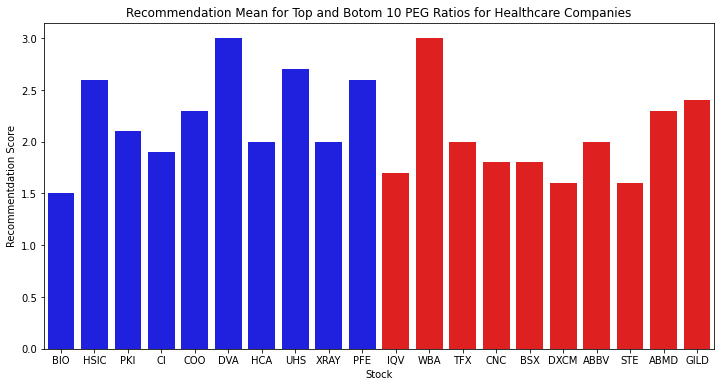

In [9]:
plt.figure(figsize = (12,6))
ax = sns.barplot(data = dfpeg,
            x = 'Stock',
            y = 'recommendationMean',
            palette = dfpeg['color'])
ax.set(title = 'Recommendation Mean for Top and Botom 10 PEG Ratios for Healthcare Companies',
       ylabel = 'Recommentdation Score')
plt.show()

### Price to Book Ratio

The last metric I'll take a look at is the price to book value.  For this, you can look at the current stock pricec and divide by the book value of the equity.  A lower value is sought after here because it means there is an abundance of assets that could pay for the stock should they have to liquidate.  Below is a graph of the top and bottom 10 values for P/B in the healthcare industry.  While this graph shows a great variability in the values for the highest P/B ratios, this makes the lowest P/B ratio stocks lack any differentiation.

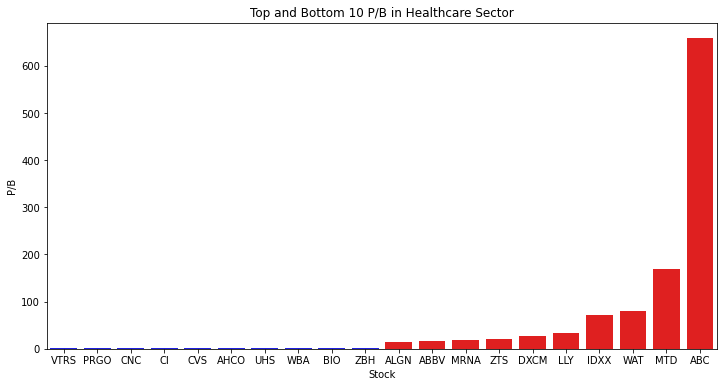

In [10]:
df_top = dfhealth.nlargest(10, columns = 'P/B')
df_top['color'] = 'red'
df_bot = dfhealth.nsmallest(10, columns = 'P/B')
df_bot['color'] = 'blue'
# combine and sort values in ascending order
dfpb = pd.concat([df_top, df_bot]).sort_values('P/B')

plt.figure(figsize = (12,6))
ax = sns.barplot(data = dfpb,
            x = 'Stock',
            y = 'P/B',
            palette=dfpb['color'])
ax.set(title = 'Top and Bottom 10 P/B in Healthcare Sector')
plt.show()

Looking at the Recommendation Score for each company, I see that there is a very small correlation for recommending a stock with lower P/B.

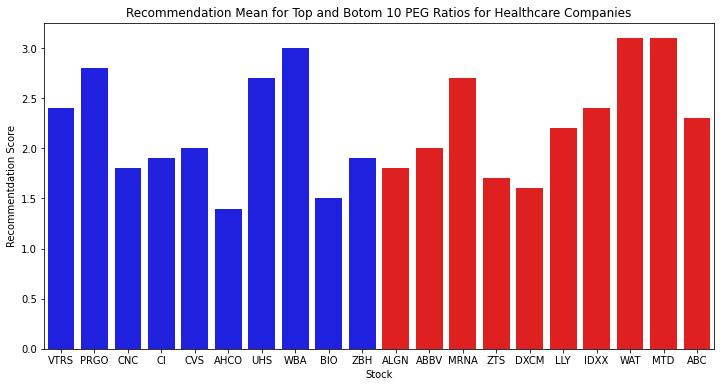

In [11]:
plt.figure(figsize = (12,6))
ax = sns.barplot(data = dfpb,
            x = 'Stock',
            y = 'recommendationMean',
            palette = dfpb['color'])
ax.set(title = 'Recommendation Mean for Top and Botom 10 PEG Ratios for Healthcare Companies',
       ylabel = 'Recommentdation Score')
plt.show()

## Final Analysis Thoughts

While several of the metrics evaluated do make sense as to why a stock would be a good buy, I cannot find any strong indicators between fundamental metrics and analyst recommendations for the healthcare industry.  However, this doesn't necessarily mean that these metrics aren't meaningful.  There may be a complex interaction between several of them that gives analyst insights.  For this, I will continue onto the final part of this report and develop a model to predict the analyst recommendation scores based on the metrics gathered.

# Part 3: Regression Modeling

Since the interactions between several of the metrics gathered may be needed to be taken into account, I have decided to work on a machine learning model to predict the Recommendation Mean Score for each individual company.

## Develop a Working Model

My first step is to develop a model that runs and then optimize later on.  For model selection, I have decided to start with XGBoost.  This is a popular approach for tabular datasets like the one I created and is easier on computer resources than deep learning models allowing for easier iterations.

In [18]:
# import relevant libraries for modeling
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

In [13]:
# Download raw data
X = pd.read_csv('all_stocks.csv', encoding='utf-8-sig')

# Start by cleaning the objective as there were a few values it couldn't pull.  For now, I will assume to replace with the
# Average of the column
X['recommendationMean'] = X['recommendationMean'].replace(np.nan, X['recommendationMean'].mean())

# Seperate objective prediction and rest of data
y = X.recommendationMean

# Drop both Mean and Key to prevent data leakage since they are related
# Also drop shortName and Stock as I believe it is not an accurate predictor of if something will be high value
X.drop(['recommendationMean','recommendationKey','shortName','Stock'], axis = 1, inplace = True)

# I will start my imputation process before the split.  For industries that are not marked, I will categorize them as "unknown"
X['Industry'] = X['Industry'].replace(np.nan, 'Unknown')

# split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=123)

# One-hot encode the industry Column
X_train = pd.get_dummies(X_train)
X_train = pd.get_dummies(X_train)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

# There are several missing values that must be dealt with before being able to model the set
base_imputer = SimpleImputer()
X_train_imputed = pd.DataFrame(base_imputer.fit_transform(X_train))
X_valid_imputed = pd.DataFrame(base_imputer.transform(X_valid))

X_train_imputed.columns = X_train.columns
X_valid_imputed.columns = X_valid.columns

X_train = X_train_imputed
X_valid = X_valid_imputed

# Define the model
base_model = XGBRegressor(random_state = 123)

# Fit the model
base_model.fit(X_train, y_train)

# Get predictions
base_predictions = base_model.predict(X_valid)

# Calculate Error
base_error = mean_squared_error(y_valid, base_predictions)

print('Mean Squared Error for the base case is:', base_error)

Mean Squared Error for the base case is: 0.1343382779083884


## Optimization

Great! Now that the model is working, I will optimize the model parameters using a randomized search as there is minimal data and searching should not take long (less than a minute for me in this case).

In [40]:
# hyperparameter optimizations
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}


clf = RandomizedSearchCV(estimator=base_model,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1,
                         random_state = 123)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)
print("Lowest Mean Squared Error: ", (-clf.best_score_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'subsample': 0.7, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4}
Lowest Mean Squared Error:  0.12789389132166837


Now that I have some optimized parameters, I will re-run the model and evaluate with the validation dataset.

In [45]:
opt_model = XGBRegressor(random_state = 123,
                         subsample = 0.7,
                         n_estimators = 1000,
                         max_depth = 3,
                         learning_rate = 0.01,
                         colsample_bytree = 0.7,
                         colsample_bylevel = 0.4)

# Fit the model
opt_model.fit(X_train, y_train)

# Get predictions
opt_predictions = opt_model.predict(X_valid)

# Calculate Error
opt_error = mean_squared_error(y_valid, opt_predictions)

print('Mean Squared Error for the optimized case is:', opt_error)

Mean Squared Error for the optimized case is: 0.11521405922320396


After optimizing, it looks like the Mean Squared Error was able to be reduced by ~15%.  Now, I would like to evaluate the model a little more and see what features are most important.  Luckily, with XGBoost, the feature importance weights of the model is stored and can easily be looked at.

### Feature Importance

Viewing my model's importance, it seems like Current Price and PEG are two of the most importance variables.  I would like to explore these two variables more before moving forward more to see what insight I can glean.

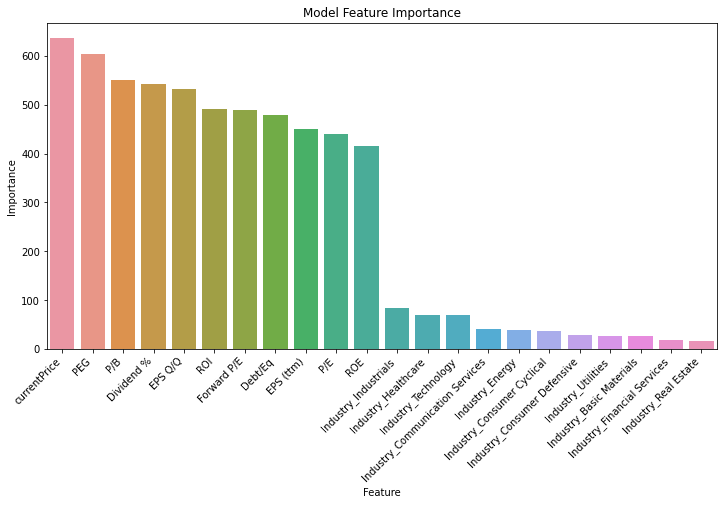

In [46]:
feature_important = opt_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

plt.figure(figsize = (12,6))
ax = sns.barplot(x = data.index,
                 y = data.score)
ax.set(title = 'Model Feature Importance',
       ylabel = 'Importance',
       xlabel = 'Feature')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

### Model Top Importance Analysis
The first variable I'll look at is Current Price for all stocks.  The below scatterplot shows the Current Price vs. the Recommendation Score with a locally weighted line to evaluate trends in different sections of the figure.

Looking at the graph where the density of points is highest (between 0 and 750), analysts seem more likely to recommend stocks with a a higher Current Price.  While Current Price seems like a factor that wouldn't matter in today's market becuase of fractional shares trading, this may be the case because companies that have recently rallied tend to have higher stock prices and the the rally makes analysts like them more.

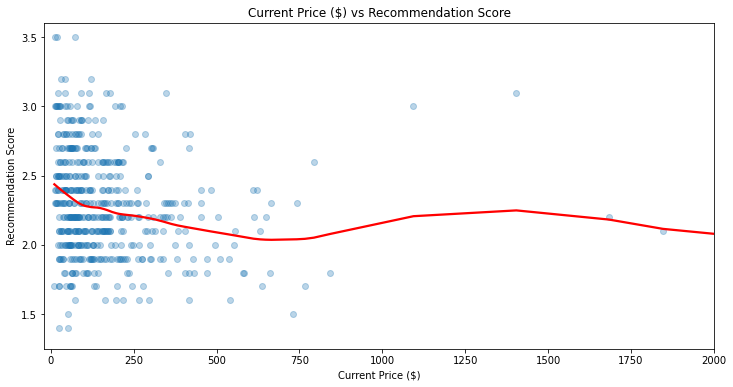

In [55]:
plt.figure(figsize = (12,6))

ax = sns.regplot(data = df2,
                     x = 'currentPrice',
                     y = 'recommendationMean',
                     scatter_kws={'alpha':0.3},
                     line_kws={'color': 'red'},
                     lowess = True) # lowess chosen to help visualize different sections
ax.set(xlim = (-20, 2000),
       ylim = (1.25, None),
       title = 'Current Price ($) vs Recommendation Score',
       xlabel = 'Current Price ($)',
       ylabel = 'Recommendation Score')

plt.show()

Taking a second look at the PEG value, it seems like lower is not always better.  There is a local minimum around 2 which is against my previous thoughts that the lower the better, as it looks like analysts do not agree with that statement.  This could explain why taking the top and bottom 10 healthcare companies did not show the results as expected.

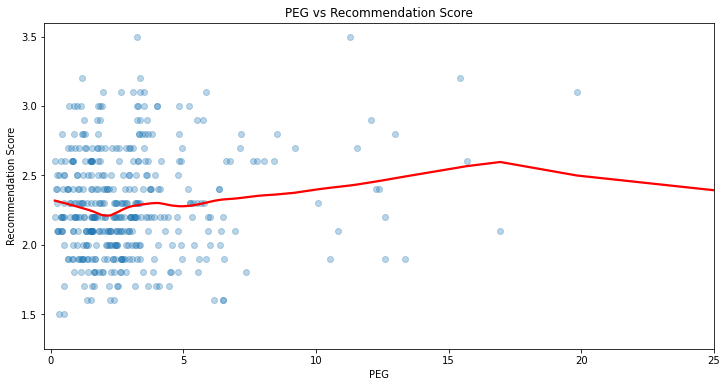

In [61]:
plt.figure(figsize = (12,6))

ax = sns.regplot(data = df2,
                     x = 'PEG',
                     y = 'recommendationMean',
                     scatter_kws={'alpha':0.3},
                     line_kws={'color': 'red'},
                     lowess = True) # lowess chosen to help visualize different sections
ax.set(xlim = (-0.25, 25),
       ylim = (1.25, None),
       title = 'PEG vs Recommendation Score',
       xlabel = 'PEG',
       ylabel = 'Recommendation Score')

plt.show()

# Part 4: Classification Modeling

Since the Recommendation Scoring results in an action by the analyst (Strong Buy, Buy, Hold, Sell, or Strong Sell), I decided to take the same question and reframe it from a Regression problem to a Classification one.  While the results will hopefully be similar, it provides a different frame of mind to analyze the problem with.

For this, we will still be usingng XGBoost and I'll start by getting a working model.  Both accuracy and log loss were used as metrics for evaluation to give a more comphrensive overlook of how the model may be improving.

In [17]:
# import relevant libraries
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, accuracy_score

In [109]:
# Download raw data
X = pd.read_csv('all_stocks.csv', encoding='utf-8-sig')

# Start by cleaning the objective as there were a few values it couldn't pull.  For now, I will assume to replace with the
# replace any value that had 'none' with NaN for imputing in the next step
X.recommendationKey = X.recommendationKey.replace('none', np.NaN)

# Most Frequent for column
X['recommendationKey'] = SimpleImputer(strategy="most_frequent").fit_transform(
    X['recommendationKey'].values.reshape(-1,1)
)

# Seperate objective prediction and rest of data
y = X.recommendationKey

# Drop both Mean and Key to prevent data leakage since they are related
# Also drop shortName and Stock as I believe it is not an accurate predictor of if something will be high value
X.drop(['recommendationMean','recommendationKey','shortName','Stock'], axis = 1, inplace = True)

# I will start my imputation process before the split.  For industries that are not marked, I will categorize them as "unknown"
X['Industry'] = X['Industry'].replace(np.nan, 'Unknown')

# encode string class values as integers
label_encoder = LabelEncoder().fit(y)
label_encoded_y = label_encoder.transform(y)

# split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, label_encoded_y, train_size=0.8, test_size=0.2,
                                                                random_state=123)

# One-hot encode the industry Column
X_train = pd.get_dummies(X_train)
X_train = pd.get_dummies(X_train)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

# There are several missing values that must be dealt with before being able to model the set
base_imputer = SimpleImputer()
X_train_imputed = pd.DataFrame(base_imputer.fit_transform(X_train))
X_valid_imputed = pd.DataFrame(base_imputer.transform(X_valid))

X_train_imputed.columns = X_train.columns
X_valid_imputed.columns = X_valid.columns

X_train = X_train_imputed
X_valid = X_valid_imputed

# Define the model
base_model = XGBClassifier(random_state = 123,
                           eval_metric = 'mlogloss',
                           use_label_encoder=False)

# Fit the model
base_model.fit(X_train, y_train)

# Get predictions
base_predictions = base_model.predict(X_valid)

# Calculate Error
base_acc_error = accuracy_score(y_valid, base_predictions)

print('Accuracy for the base case is:', base_acc_error)

# Get predictions with probabilities
base_prob_predictions = base_model.predict_proba(X_valid)

# Calculate Error
base_log_error = log_loss(y_valid, base_prob_predictions)

print('Log Loss for the base case is:', base_log_error)

Accuracy for the base case is: 0.7115384615384616
Log Loss for the base case is: 0.9332922629926963


Now that the model is up and running, let's optimize it based on accuracy using the same Randomized Search as before.

One item to note is that during this process, the issue came up that for the sample size of stocks, only *Strong Buy*, *Buy*, and *Hold* recommendations appear in the dataset.  The lack of choices creates some warnings in the output.

In [110]:
# hyperparameter optimizations
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}


clf = RandomizedSearchCV(estimator=base_model,
                         param_distributions=params,
                         scoring='accuracy',
                         n_iter=25,
                         verbose=1,
                         random_state = 123)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)
print("Accuracy: ", (clf.best_score_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\Michael\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.5}
Accuracy:  0.7734939759036145


Running the model with the optimized parameters, we can see a ~4% increase in accuracy and a 0.25 reduction in log loss showing that the model did improve.

In [111]:
opt_model = XGBClassifier(random_state = 123,
                          subsample = 0.9,
                          n_estimators = 1000,
                          max_depth = 3,
                          learning_rate = 0.01,
                          colsample_bytree = 0.6,
                          colsample_bylevel = 0.5,
                          eval_metric = 'mlogloss',
                          use_label_encoder=False)

# Fit the model
opt_model.fit(X_train, y_train)

# Get predictions
opt_predictions = opt_model.predict(X_valid)

# Calculate Error
opt_error = accuracy_score(y_valid, opt_predictions)

print('Accuracy for the optimized case is:', opt_error)

# Get predictions with probabilities
opt_prob_predictions = opt_model.predict_proba(X_valid)

# Calculate Error
opt_log_error = log_loss(y_valid, opt_prob_predictions)

print('Log Loss for the optimized case is:', opt_log_error)

Accuracy for the optimized case is: 0.7596153846153846
Log Loss for the optimized case is: 0.679253989794793


For reference, I decided to create a variable that converts the classifying numbers back into recommendations for easier recommendation interpretation.

In [112]:
# Convert the encoded values back into understandable language
final_recommendations = label_encoder.inverse_transform(opt_predictions)

# Part 5: Unsupervised Learning (K-means Clustering)

To continue understanding the stock market, I am going to perform a K-means Clustering analysis to see what commonalities certain stocks have to one and other.  The most straight forward one that is already classified is industry, but I'm curious what other factors the statistics will key off of.

In [65]:
# Import relevant libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [66]:
# The data cleaning is the same as used in the Supervised ML models
Xraw = pd.read_csv('all_stocks.csv', encoding='utf-8-sig')
X = Xraw.copy()

# Start by cleaning the objective as there were a few values it couldn't pull.  For now, I will assume to replace with the
# replace any value that had 'none' with NaN for imputing in the next step
X.recommendationKey = X.recommendationKey.replace('none', np.NaN)

# Most Frequent for column
X['recommendationKey'] = SimpleImputer(strategy="most_frequent").fit_transform(
    X['recommendationKey'].values.reshape(-1,1)
)

# Drop both Mean and Key to prevent data leakage since they are related
# Also drop shortName and Stock as I believe it is not an accurate predictor of if something will be high value
X.drop(['recommendationMean','recommendationKey','shortName','Stock','recommendationKey'], axis = 1, inplace = True)

# I will start my imputation process before the split.  For industries that are not marked, I will categorize them as "unknown"
X['Industry'] = X['Industry'].replace(np.nan, 'Unknown')

# One-hot encode the industry Column
X = pd.get_dummies(X)

# There are several missing values that must be dealt with before being able to model the set
base_imputer = SimpleImputer()
X_imputed = pd.DataFrame(base_imputer.fit_transform(X))
X_imputed.columns = X.columns
X = X_imputed

In [67]:
# For this analysis, the data frame will be scaled as the large range difference between 
# number types gives disproportionate weight to higher numbers
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [68]:
# Define a base case model
kmeans_base = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

# Calculate the cluster based on the scaled values
y_predicted_base = kmeans_base.fit_predict(scaled_X)

# Add the predictions to the raw values
Xraw['cluster_base'] = y_predicted_base

Now that a base model has been created, I am going to use a method to more appropriately choose the number of clusters.  For this, I will use the **elbow point** method which can be easily evaluated graphically. This looks at the Sum of Squares Error (SSE) and is meant to balance the error and the number of clusters.

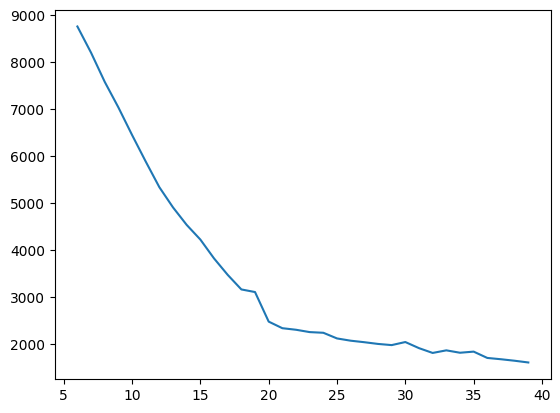

In [69]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(6, 40):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_X)
    sse.append(kmeans.inertia_) # lowest SSE value

ax = sns.lineplot(x = range(6,40),
                  y = sse)

Looking at the graph, I estimate the optimal number of clusters to be around 21.  Now, I am going to perform the analysis again with 21 clusters to see how the stocks cluster.

In [70]:
# Define an optimized model
kmeans_base = KMeans(
    init="random",
    n_clusters=21,
    n_init=10,
    max_iter=300,
    random_state=42
)

# Calculate the cluster based on the scaled values
y_predicted_opt = kmeans_base.fit_predict(scaled_X)

# Add the predictions to the raw values
Xraw['cluster_opt'] = y_predicted_opt

Looking at the final clusters, it seems that the model has picked up on the industry as one of the best classes to group upon.  Several of the clusters only have one type of industry in them or are largely dominated by one type.  Some other interesting groupings include cluster 20, which seems to have simply looked at the current stock price as all of the stock prices are over $1,500 a share.  An interesting grouping that I would like to explore more is Cluster 12 where together two cruise companies, Tesla, Live Nation, and DexCom have been linked together, which makes me very curious what they have in common.

# Part 6: Conclusions and Final Thoughts

Looking at the fundamental values, I feel like I've learned a significant amount about the stock market.  However, there is still much knowledge to be gathered about how to ideally pick stocks for a portfolio.  Fortunately, with the webscraping skills used, I believe that I could easily bring in more information to the models to help make predictions. Additionally, pulling the same data for multiple time periods could help improve the model with more data.  For now though, I will stick with investing in broad index funds for the long term.

